
<Panel 1>
R2 for SV-PV plot: 0.8364
R2_good for SV-PV plot: 0.8988

<Panel 2>
[All] N: 73, 0.05: 49, 0.10: 64, sigma: 0.061, mean: -0.011
[Good] N: 25, 0.05: 23, 0.10: 24, sigma: 0.039, mean: 0.001

<Panel 3>
R2 for lastS-PV: 0.5010
R2_good for lastS-PV: 0.3769

<Panel 4>
[All] N: 73, 0.05: 27, 0.10: 51, sigma: 0.108, mean: 0.000


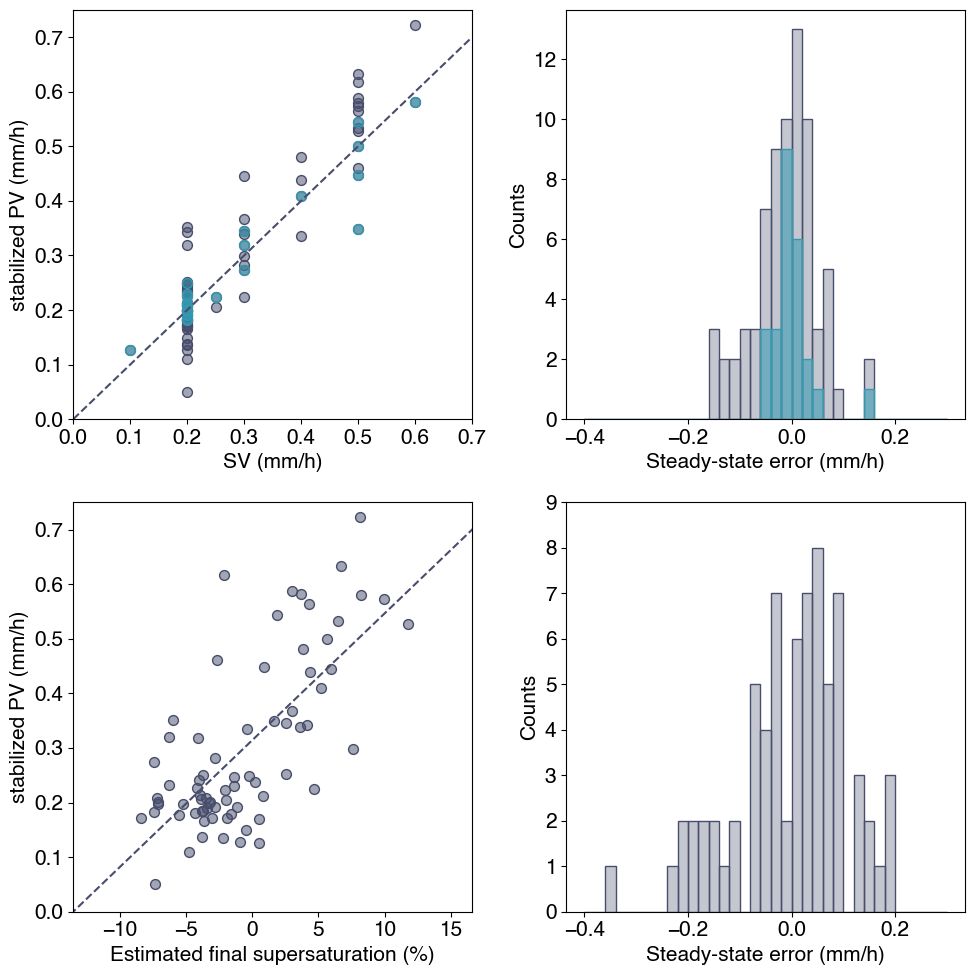

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.metrics import r2_score

# figure save option
save_option = True
figsavepath = "../Figures/Figure4_control-system.svg"

color1 = "#474D6B" # dark blue
color2 = '#3498B0' # light blue

## Data ##
path = "../Data/01_SUMMARY.xlsx"
df = pd.read_excel(path,sheet_name='Data2') # removed uncontrolled

Evap = df['Evap'].to_list()
Est_evap = df['Est_Evap'].to_list()
E_error = [m-n for m,n in zip(Est_evap,Evap)] # estimation error
Last_c = df['Last_C'].to_list()
PVs = df['PV'].to_list()
SVs = df['SV'].to_list()

# remove failed data
False_check = df['FALSE'].to_list()
False_indices = [i for i, x in enumerate(False_check) if x == 1]
for index in sorted(False_indices, reverse=True):
    del Last_c[index]
    del SVs[index]
    del PVs[index]
    del E_error[index]

# remove nan
nan_indices = [i for i, x in enumerate(SVs) if isinstance(x, float) and math.isnan(x)]
for index in sorted(nan_indices, reverse=True):
    del Last_c[index]
    del SVs[index]
    del PVs[index]
    del E_error[index]
    
nan_indices = [i for i, x in enumerate(PVs) if isinstance(x, float) and math.isnan(x)]
for index in sorted(nan_indices, reverse=True):
    del Last_c[index]
    del SVs[index]
    del PVs[index]
    del E_error[index]
    
nan_indices = [i for i, x in enumerate(Last_c) if isinstance(x, float) and math.isnan(x)]
for index in sorted(nan_indices, reverse=True):
    del Last_c[index]
    del SVs[index]
    del PVs[index]
    del E_error[index]

# Solubility calculation
def temp_in_solution(time):
    # temperature profile *see FigS2
    T0 = 21.3767
    Tend = 40.6191
    k = 4.1604
    y = Tend + (T0 - Tend) * np.exp(-k * time) # time (hrs), temp (oC), based on Figure S2
    return y

def solubility(time):
    T = temp_in_solution(time)
    S = 1.66151429e-03 * T * T - 5.54452231e-01 * T + 6.11548397e+01
    return S

def supersaturation(time, C):
    S = solubility(time)
    sigma = (C-S)/S*100 #%
    return sigma

stabilized_solubility = solubility(1000) # solubility at the stabilized temperature (100 hrs later)
Last_supersaturation = [(x-stabilized_solubility)/stabilized_solubility*100 for x in Last_c]

Error_SVPV = [m-n for m,n in zip(SVs,PVs)] # steady-state errors for panel c

# Data classification based on evaporation estimation
estimation_threshold = 0.1
Error_SVPV_good, SVs_good, PVs_good, Last_s_good = [], [], [], []
for x, y1, y2, y3, y4 in zip(E_error,Error_SVPV, SVs, PVs, Last_supersaturation):
    if abs(x) < estimation_threshold:
        Error_SVPV_good.append(y1)
        SVs_good.append(y2)
        PVs_good.append(y3)
        Last_s_good.append(y4)
        
### Figure Plot ###
plt.rcParams["font.size"] = 15
plt.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10,10))

# Panel 00
# Fitted curve which is PV = SV
X_fit1 = np.arange(0,0.71,0.01)
Y_fit1 = X_fit1
axes[0][0].plot(X_fit1, Y_fit1, linestyle='dashed', color=color1)
axes[0][0].scatter(SVs,PVs, s=50, color=f'{color1}80',ec=color1, linewidths=1)
axes[0][0].scatter(SVs_good,PVs_good, s=50, color=f"{color2}80",ec=f"{color2}", linewidths=1)
axes[0][0].set_xlabel('SV (mm/h)')
axes[0][0].set_ylabel('stabilized PV (mm/h)')
axes[0][0].set_xlim(0,0.7)
axes[0][0].set_ylim(0,0.75)
axes[0][0].set_xticks(np.arange(0, 0.8, 0.1))
axes[0][0].set_yticks(np.arange(0, 0.8, 0.1))

# R2 for C
r2_1 = r2_score(PVs, SVs)
r2_1_good = r2_score(PVs_good,SVs_good)
print(f'\n<Panel 1>')
print(f'R2 for SV-PV plot: {r2_1:.4f}')
print(f'R2_good for SV-PV plot: {r2_1_good:.4f}')

# Panel 01
bin_width = 0.02
bin_edges = np.arange(start=-0.4, stop=0.3 + bin_width, step=bin_width)


axes[0][1].hist(Error_SVPV,color=f"{color1}50", ec=color1, bins = bin_edges, label='All')
axes[0][1].hist(Error_SVPV_good,color=f"{color2}90", ec=color2, bins = bin_edges,label='<0.1 g/h estimation')
axes[0][1].set_xlabel('Steady-state error (mm/h)')
axes[0][1].set_ylabel('Counts')
print(f'\n<Panel 2>')
count2_01 = sum(1 for x in Error_SVPV if abs(x) <= 0.1)
count2_005 = sum(1 for x in Error_SVPV if abs(x) <= 0.05)
print(f'[All] N: {len(Error_SVPV)}, 0.05: {count2_005}, 0.10: {count2_01}, sigma: {np.std(Error_SVPV):.3f}, mean: {np.mean(Error_SVPV):.3f}')
count2_01_good = sum(1 for x in Error_SVPV_good if abs(x) <= 0.1)
count2_005_good = sum(1 for x in Error_SVPV_good if abs(x) <= 0.05)
print(f'[Good] N: {len(Error_SVPV_good)}, 0.05: {count2_005_good}, 0.10: {count2_01_good}, sigma: {np.std(Error_SVPV_good):.3f}, mean: {np.mean(Error_SVPV_good):.3f}')


# Panel 10
axes[1][0].scatter(Last_supersaturation,PVs,c=f"{color1}80",ec=color1,s=50,linewidth=1)
axes[1][0].set_xlabel('Estimated final supersaturation (%)')
axes[1][0].set_ylabel('stabilized PV (mm/h)')
a, b = np.polyfit(Last_supersaturation,PVs,1)
x_line = [-15,25]
y_line = [a*n+b for n in x_line]
axes[1][0].plot(x_line, y_line, c = color1, linestyle='dashed')

axes[1][0].set_xlim(-b/a,(0.7-b)/a)
axes[1][0].set_ylim(0,0.75)
axes[1][0].set_xticks(np.arange(-10,20,5))

print(f'\n<Panel 3>')
# R2 for 10
r2_2 = r2_score(PVs, [a*n+b for n in Last_supersaturation])
print(f'R2 for lastS-PV: {r2_2:.4f}')
r2_2_good = r2_score(PVs_good, [a*n+b for n in Last_s_good])
print(f'R2_good for lastS-PV: {r2_2_good:.4f}')

# Panel 11
Y1 = [m-n for m,n in zip([a*n+b for n in Last_supersaturation],PVs)]
axes[1][1].hist(Y1,color=f"{color1}50", ec=color1, bins = bin_edges)
axes[1][1].set_xlabel('Steady-state error (mm/h)')
axes[1][1].set_ylabel('Counts')
axes[1][1].set_ylim(0,9)

print(f'\n<Panel 4>')
count1_01 = sum(1 for x in Y1 if abs(x) <= 0.1)
count1_005 = sum(1 for x in Y1 if abs(x) <= 0.05)
print(f'[All] N: {len(Y1)}, 0.05: {count1_005}, 0.10: {count1_01}, sigma: {np.std(Y1):.3f}, mean: {np.mean(Y1):.3f}')

if save_option:
    plt.savefig(figsavepath, dpi=1200, bbox_inches='tight', transparent=True)